# <u>Emotion detection from facial expressions
The aim of the problem is to find the emotion of a person by looking at the facial expression of that person. <br>The dataset used for this problem is from the Kaggle Challenge [Challenges in Representation Learning: Facial Expression Recognition Challenge](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data)

The task is to categorize each face based on the emotion shown in the facial expression in to one of seven categories:<br> 
- 0: Angry 
- 1:Disgust
- 2: Fear
- 3: Happy
- 4: Sad
- 5: Surprise
- 6: Neutral

In [1]:
# load the required modules
import pandas as pd
import numpy as np
from keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
import cv2

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras import callbacks
from keras.callbacks import EarlyStopping
from keras.layers import MaxPool2D
%matplotlib inline

C:\Users\SUSANTA\Anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# <u>Data Preparation
The training set consists of 28,709 examples.
<br>The test set consists of 3,589 examples. 
<br>The cross validation set consists of another 3,589 examples.
There is a csv file containing the emotion values for all the data.

In [2]:
# load the images
images_train = np.load('dataset/train_raw.npy')

In [3]:
# load the cross validation images
images_cv = np.load('dataset/cv_raw.npy')
# load the test images
images_test = np.load('dataset/test_raw.npy')

In [4]:
# load the corresponding emotion values
emotions = pd.read_csv('dataset/emotions.csv', header=None)

In [5]:
print(len(images_train))
print(len(images_cv))
print(len(images_test))
print(len(emotions))

28709
3589
3589
35887


### Data distribution

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000161B6EC5048>]],
      dtype=object)

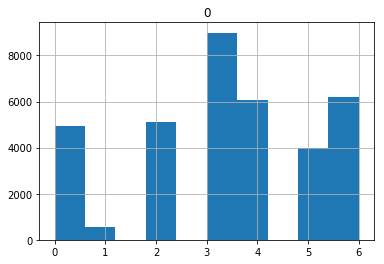

In [6]:
# data distribution
emotions.hist()

In [7]:
# distribution of pictures
emotions[0].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: 0, dtype: int64

### Prepare output labels

In [8]:
# prepare output labels for train, cv and test
y_train = emotions[:images_train.shape[0]].values
y_cv = emotions[images_train.shape[0]:images_train.shape[0] + images_cv.shape[0]].values
y_test = emotions[images_train.shape[0] + images_cv.shape[0]: ].values

In [9]:
print(y_train.shape)
print(y_cv.shape)
print(y_test.shape)

(28709, 1)
(3589, 1)
(3589, 1)


In [10]:
# create one hot encoding
y_train_ohe = to_categorical(y_train, num_classes=7)
y_cv_ohe = to_categorical(y_cv, num_classes=7)
y_test_ohe = to_categorical(y_test, num_classes=7)

In [11]:
print(y_train_ohe.shape)
print(y_cv_ohe.shape)
print(y_test_ohe.shape)

(28709, 7)
(3589, 7)
(3589, 7)


### Sanity checking 

In [12]:
# for displaying an image from dataset
def show(img):
    # resize the image
    show_image = img.reshape(48,48)
    # show the image
    plt.imshow(show_image, cmap='gray')

Emotion:[0]


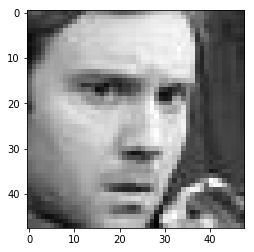

In [13]:
# verify the image with its label
index = 0
# training image
show(images_train[index])
print('Emotion:' + str(y_train[index]))

Emotion:[0]


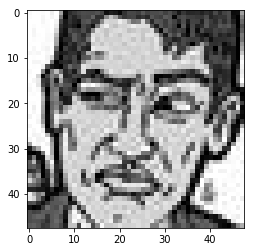

In [14]:
# cv image
show(images_cv[index])
print('Emotion:' + str(y_cv[index]))

Emotion:[0]


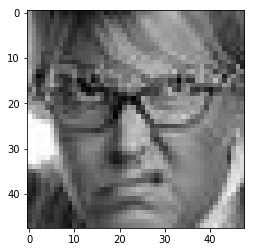

In [15]:
# test image
show(images_test[index])
print('Emotion:' + str(y_test[index]))

# <u>Preprocessing

In [16]:
# reshape the images for keras model
images_train = np.expand_dims(images_train, 3)
images_cv = np.expand_dims(images_cv, 3)
images_test = np.expand_dims(images_test, 3)

In [17]:
print(images_train.shape)
print(images_cv.shape)
print(images_test.shape)

(28709, 48, 48, 1)
(3589, 48, 48, 1)
(3589, 48, 48, 1)


# <u>Model Architecture

In [0]:
from keras.utils import plot_model
import pydot
#plot_model(model, to_file='drive/Colab Notebooks/model.png', show_shapes=True)


In [18]:
# save the model weights after each epoch if the validation loss decreases
checkpoint = ModelCheckpoint(filepath='models/weights_best.hdf5', verbose=1, save_best_only=True)

In [19]:
# load already saved model if needed
if os.path.exists('models/model.h5'):
    model = load_model('models/model.h5')
else:
    print('No model to load !')

### Make the model

In [20]:
model = Sequential()

# 1st stage
model.add(Conv2D(32, 3, input_shape=(48, 48, 1), padding='same', 
                 activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, 3, padding='same', 
                 activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

# 2nd stage
model.add(Conv2D(64, 3, padding='same', 
                 activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, 3, padding='same', 
                 activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.25))

# 3rd stage
model.add(Conv2D(128, 3, padding='same', 
                 activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, 3, padding='same', 
                 activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2), strides=2))
model.add(Dropout(0.25))

# FC layers
model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(7))
model.add(Activation('softmax'))

In [65]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 48, 48, 32)        320       
_________________________________________________________________
batch_normalization_18 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 48, 48, 32)        9248      
_________________________________________________________________
batch_normalization_19 (Batc (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
batch_normalization_20 (Batc (None, 24, 24, 64)        256       
__________

In [21]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### NOTE: The model was trained for 50 epochs but was done not in one go, so in the fit function there is only 5 written as it was the last time the model was run

In [72]:
# start training the model
hist = model.fit(images_train, y_train_ohe, batch_size=128, epochs=5, verbose=1,
          validation_data=(images_cv, y_cv_ohe), shuffle=True, callbacks=[checkpoint])

# save the current model and weights
model.save_weights('models/weights.h5')
model.save('models/model.h5')

Train on 28709 samples, validate on 3589 samples
Epoch 1/5
28709/28709 [==============================] - 29s 1ms/step - loss: 0.1516 - acc: 0.9484 - val_loss: 1.8035 - val_acc: 0.6252

Epoch 00001: val_loss did not improve
Epoch 2/5
27264/28709 [===========================>..] - ETA: 1s - loss: 0.1542 - acc: 0.948228709/28709 [==============================] - 29s 1ms/step - loss: 0.1553 - acc: 0.9479 - val_loss: 1.7623 - val_acc: 0.6317

Epoch 00002: val_loss did not improve
Epoch 3/5
28709/28709 [==============================] - 29s 1ms/step - loss: 0.1512 - acc: 0.9473 - val_loss: 1.7439 - val_acc: 0.6297

Epoch 00003: val_loss did not improve
Epoch 4/5
11904/28709 [===========>..................] - ETA: 16s - loss: 0.1455 - acc: 0.950228709/28709 [==============================] - 29s 1ms/step - loss: 0.1536 - acc: 0.9469 - val_loss: 1.7773 - val_acc: 0.6311

Epoch 00004: val_loss did not improve
Epoch 5/5
28709/28709 [==============================] - 29s 1ms/step - loss: 0.1472

## <u>Model Evaluation
The model achieves 63% accuracy on the unseen test set.

In [73]:
# training loss and accuracy
train_acc = hist.history['acc']
val_acc = hist.history['val_acc']
print('Training Accuracy: ', train_acc[-1])
print('Validation Accuracy: ', val_acc[-1])

# test loss and accuracy
score, acc = model.evaluate(images_test, y_test_ohe,
                            batch_size=32)
print('Test score:', score)
print('Test accuracy:', acc)

Training Accuracy:  0.9487268800579179
Validation Accuracy:  0.6338813039927006
3589/3589 [==============================] - 2s 498us/step
Test score: 1.743287368882297
Test accuracy: 0.6324881582779617


### Plot the training loss and accuracy graph

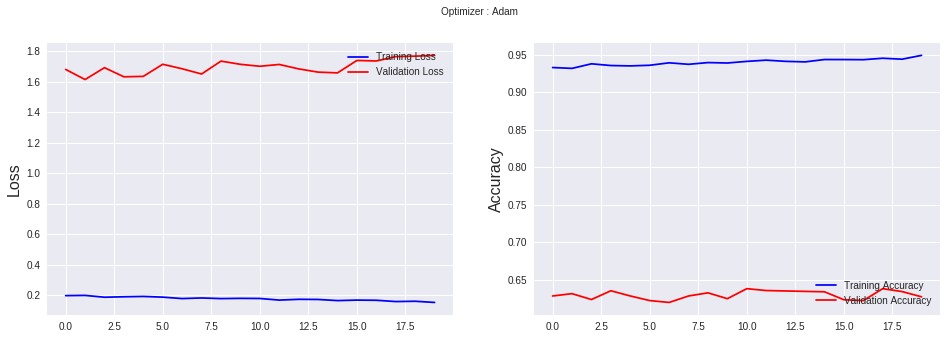

In [71]:
plt.figure(figsize=(16,5))
# training loss graph
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(hist.history['loss'], color='b', label='Training Loss')
plt.plot(hist.history['val_loss'], color='r', label='Validation Loss')
plt.legend(loc='upper right')

# training accuracy graph
plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(hist.history['acc'], color='b', label='Training Accuracy')
plt.plot(hist.history['val_acc'], color='r', label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

